In [2]:
from pydriller import Repository
import subprocess
import pandas as pd
from tqdm import tqdm

In [10]:
def clean(lines):
    return[line.strip() for line in lines if line.strip()]

def getDiff(diff):
    if diff is None:
        return ""
    lines = diff.splitlines()
    return "\n".join(clean(lines));

In [ ]:
urls = ['https://github.com/autoscrape-labs/pydoll', 'https://github.com/agent0ai/agent-zero', 'https://github.com/amueller/word_cloud']
filedict = {'old_file path':[], 'new_file path':[], 'commit_SHA':[],'parent commit SHA' : [],
             'commit_message':[], 'diff_myers':[], 'diff_hist':[]}

for url in urls:
    for commit in tqdm(Repository(path_to_repo=url,skip_whitespaces=True).traverse_commits(), desc="Processing commits"):
        for file in tqdm(commit.modified_files, desc=f"Commit {commit.hash[:7]}", leave=False):
            filedict['old_file path'].append(file.old_path)
            filedict['new_file path'].append(file.new_path)
            filedict['commit_SHA'].append(commit.hash)
            filedict['parent commit SHA'].append(commit.parents[0] if commit.parents else None)
            filedict['commit_message'].append(commit.msg)
            filedict['diff_myers'].append(getDiff(file.diff))

for url in urls:
    for commit in tqdm(Repository(path_to_repo=url, histogram_diff=True, skip_whitespaces=True).traverse_commits(), desc="Processing commits"):
        for file in tqdm(commit.modified_files, desc=f"Commit {commit.hash[:7]}", leave=False):
            filedict['diff_hist'].append(getDiff(file.diff))

df = pd.DataFrame(filedict)
df.to_csv('diffs_output.csv', index=False)

Processing commits: 0it [00:00, ?it/s]

Processing commits: 956it [02:22,  6.71it/s]
Processing commits: 767it [01:57,  6.51it/s]
Processing commits: 584it [01:24,  6.90it/s]
Processing commits: 956it [02:43,  5.85it/s]
Processing commits: 767it [01:48,  7.09it/s]
Processing commits: 584it [01:37,  6.02it/s]


In [15]:
df.head(10)

,old_file path,new_file path,commit_SHA,parent commit SHA,commit_message,diff_myers,diff_hist
0,None,.gitignore,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...","@@ -0,0 +1,163 @@\n+__pycache__/\n+*.py[cod]\n...","@@ -0,0 +1,163 @@\n+__pycache__/\n+*.py[cod]\n..."
1,None,.python-version,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...","@@ -0,0 +1 @@\n+3.12.5","@@ -0,0 +1 @@\n+3.12.5"
2,README.md,README.md,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...",,
3,None,poetry.lock,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...","@@ -0,0 +1,1000 @@\n+# This file is automatica...","@@ -0,0 +1,1000 @@\n+# This file is automatica..."
4,pydoll\__init__.py,pydoll\__init__.py,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...",,
5,pydoll\browser\__init__.py,pydoll\browser\__init__.py,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...",,
6,None,pydoll\browser\base.py,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...","@@ -0,0 +1,75 @@\n+import asyncio\n+import os\...","@@ -0,0 +1,75 @@\n+import asyncio\n+import os\..."
7,None,pydoll\browser\chrome.py,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...","@@ -0,0 +1,23 @@\n+import os\n+\n+from pydoll....","@@ -0,0 +1,23 @@\n+import os\n+\n+from pydoll...."
8,None,pydoll\browser\options.py,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...","@@ -0,0 +1,22 @@\n+class Options:\n+ def __...","@@ -0,0 +1,22 @@\n+class Options:\n+ def __..."
9,None,pydoll\connection.py,cadc730d177bbf4ef091f033fc34f53c6e020223,None,"feat: add .gitignore, .python-version, and poe...","@@ -0,0 +1,103 @@\n+import asyncio\n+from typi...","@@ -0,0 +1,103 @@\n+import asyncio\n+from typi..."


In [3]:
df = pd.read_csv("diffs_output.csv")

In [8]:
def normalize_diff(diff):
    return "\n".join([line.strip() for line in str(diff).splitlines() if line.strip()])

df["Discrepancy"] = df.apply(
    lambda row: "Yes" if normalize_diff(row["diff_myers"]) != normalize_diff(row["diff_hist"]) else "No",
    axis=1
)
discrepancy_counts = df["Discrepancy"].value_counts()
print("Discrepancy counts:")
for label, count in discrepancy_counts.items():
    print(f"  {label}: {count}")

Discrepancy counts:
  No: 6854
  Yes: 336


Mismatch counts by file type:
  Source: 296
  Test: 16
  README: 24
  LICENSE: 0


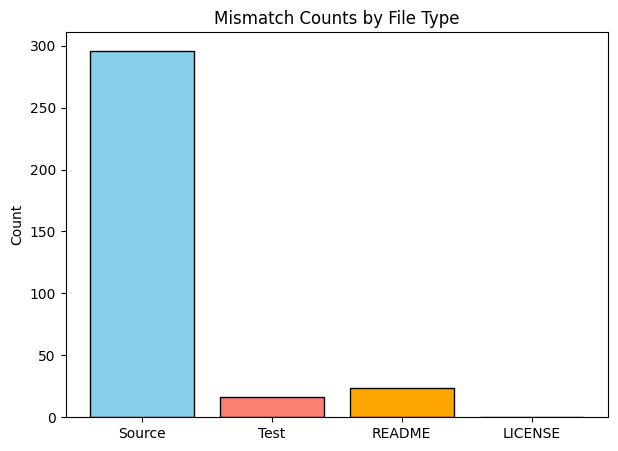

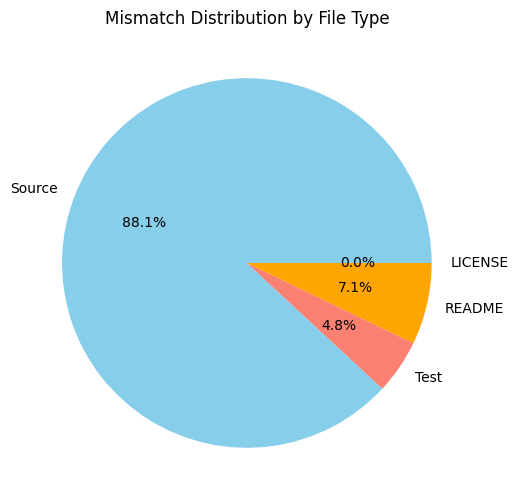

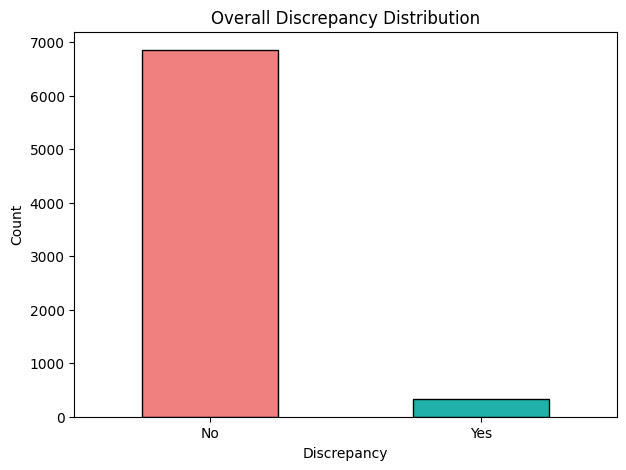

In [ ]:
import matplotlib.pyplot as plt

def categorize_file(path):
    if path is None or pd.isna(path):
        return "Other"
    filename = str(path).lower()
    if "test" in filename:
        return "Test"
    elif "readme" in filename:
        return "README"
    elif "license" in filename:
        return "LICENSE"
    else:
        return "Source"

df["file_type"] = df["new_file path"].apply(categorize_file)
mismatch_counts = df[df["Discrepancy"] == "Yes"].groupby("file_type").size()
categories = ["Source", "Test", "README", "LICENSE"]
mismatch_summary = {cat: mismatch_counts.get(cat, 0) for cat in categories}

print("Mismatch counts by file type:")
for file_type, count in mismatch_summary.items():
    print(f"  {file_type}: {int(count)}")


plt.figure(figsize=(7,5))
plt.bar(mismatch_summary.keys(), mismatch_summary.values(),
        color=["skyblue","salmon","orange","lightgreen"], edgecolor="black")
plt.title("Mismatch Counts by File Type")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,6))
plt.pie(mismatch_summary.values(), labels=mismatch_summary.keys(),
        autopct="%1.1f%%", colors=["skyblue","salmon","orange","lightgreen"])
plt.title("Mismatch Distribution by File Type")
plt.show()

plt.figure(figsize=(7,5))
df["Discrepancy"].value_counts().plot(
    kind="bar",
    color=["lightcoral","lightseagreen"],
    edgecolor="black"
)
plt.xticks(rotation=0)
plt.title("Overall Discrepancy Distribution")
plt.ylabel("Count")
plt.show()


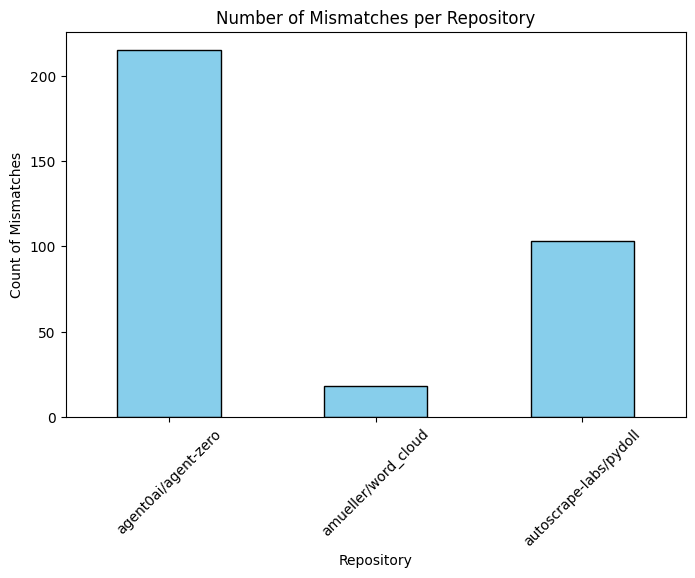

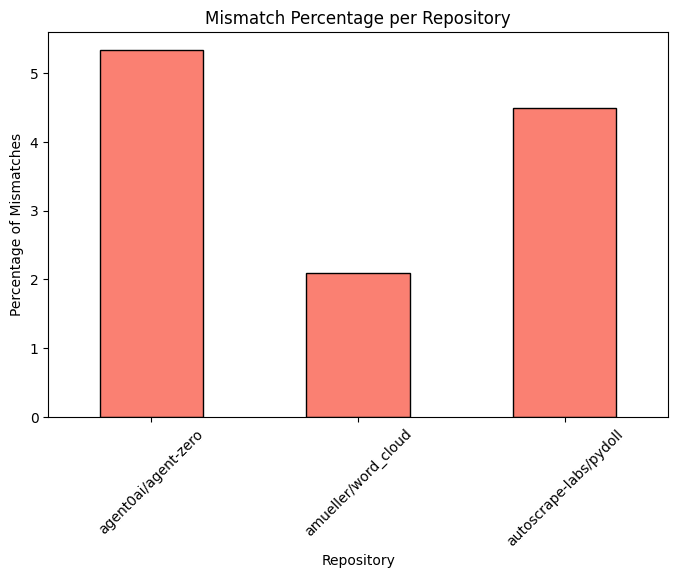

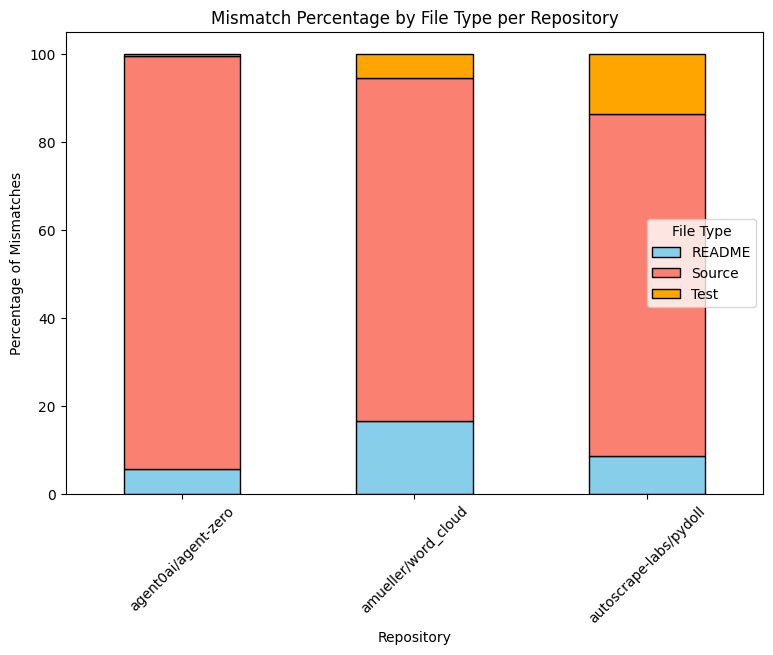

In [ ]:
def get_repo_name(url):
    return re.search(r"github\.com/([^/]+/[^/]+)", url).group(1)


commit_to_repo = {}
for url in urls:
    repo_name = get_repo_name(url)
    for commit in Repository(path_to_repo=url, skip_whitespaces=True).traverse_commits():
        commit_to_repo[commit.hash] = repo_name

repo_names = df['commit_SHA'].map(commit_to_repo)

mismatch_counts_per_repo = df[df["Discrepancy"] == "Yes"].groupby(repo_names).size()
total_files_per_repo = df.groupby(repo_names).size()
mismatch_percent_per_repo = (mismatch_counts_per_repo / total_files_per_repo * 100).fillna(0)

plt.figure(figsize=(8,5))
mismatch_counts_per_repo.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Mismatches per Repository")
plt.ylabel("Count of Mismatches")
plt.xlabel("Repository")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
mismatch_percent_per_repo.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Mismatch Percentage per Repository")
plt.ylabel("Percentage of Mismatches")
plt.xlabel("Repository")
plt.xticks(rotation=45)
plt.show()

def categorize_file(path):
    if path is None or pd.isna(path):
        return "Other"
    filename = str(path).lower()
    if "test" in filename:
        return "Test"
    elif "readme" in filename:
        return "README"
    elif "license" in filename:
        return "LICENSE"
    else:
        return "Source"

file_types = df['new_file path'].apply(categorize_file)

mismatch_df = df[df["Discrepancy"] == "Yes"]
mismatch_repo = mismatch_df['commit_SHA'].map(commit_to_repo)
mismatch_file_type = mismatch_df['new_file path'].apply(categorize_file)

counts = pd.crosstab(mismatch_repo, mismatch_file_type)

percent_counts = counts.div(counts.sum(axis=1), axis=0) * 100
percent_counts.plot(kind='bar', stacked=True, figsize=(9,6),
                    color=["skyblue", "salmon", "orange", "lightgreen", "gray"], edgecolor='black')
plt.title("Mismatch Percentage by File Type per Repository")
plt.ylabel("Percentage of Mismatches")
plt.xlabel("Repository")
plt.xticks(rotation=45)
plt.legend(title="File Type")
plt.show()


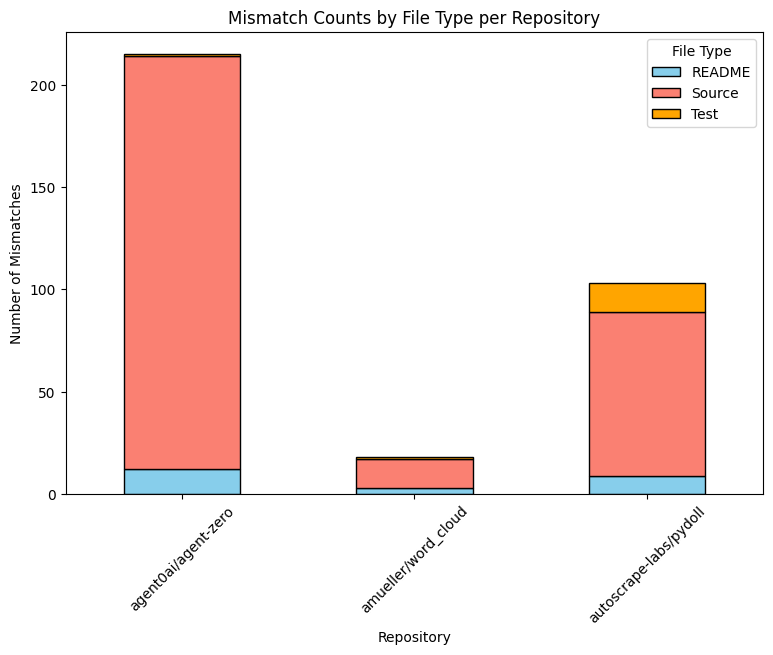

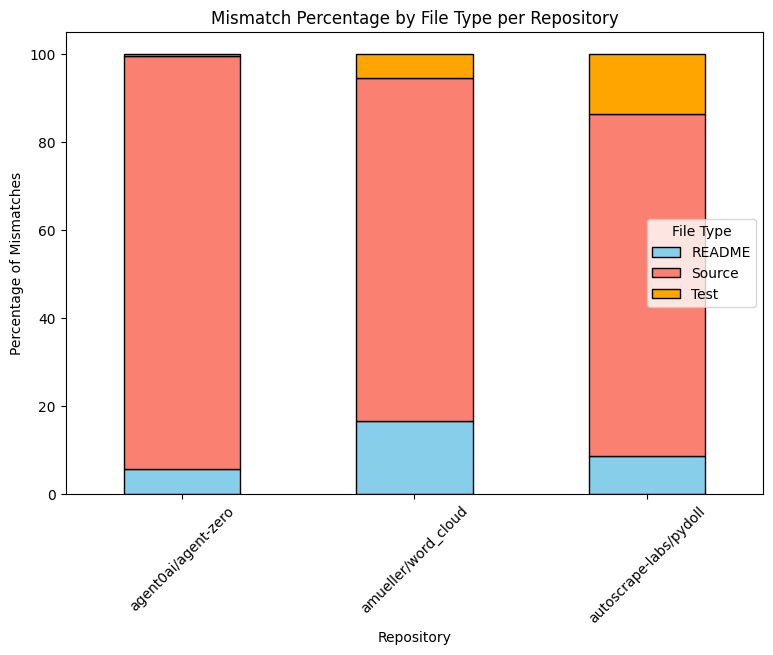

In [ ]:
import matplotlib.pyplot as plt

def get_repo_name(url):
    import re
    return re.search(r"github\.com/([^/]+/[^/]+)", url).group(1)

commit_to_repo = {}
for url in urls:
    repo_name = get_repo_name(url)
    for commit in Repository(path_to_repo=url, skip_whitespaces=True).traverse_commits():
        commit_to_repo[commit.hash] = repo_name

repo_names = df['commit_SHA'].map(commit_to_repo)

def categorize_file(path):
    if path is None or pd.isna(path):
        return "Other"
    filename = str(path).lower()
    if "test" in filename:
        return "Test"
    elif "readme" in filename:
        return "README"
    elif "license" in filename:
        return "LICENSE"
    else:
        return "Source"

file_types = df['new_file path'].apply(categorize_file)
mismatch_df = df[df["Discrepancy"] == "Yes"]
mismatch_repo = mismatch_df['commit_SHA'].map(commit_to_repo)
mismatch_file_type = mismatch_df['new_file path'].apply(categorize_file)
counts.plot(kind='bar', stacked=True, figsize=(9,6),
            color=["skyblue", "salmon", "orange", "lightgreen", "gray"], edgecolor='black')
plt.title("Mismatch Counts by File Type per Repository")
plt.ylabel("Number of Mismatches")
plt.xlabel("Repository")
plt.xticks(rotation=45)
plt.legend(title="File Type")
plt.show()

percent_counts = counts.div(counts.sum(axis=1), axis=0) * 100
percent_counts.plot(kind='bar', stacked=True, figsize=(9,6),
                    color=["skyblue", "salmon", "orange", "lightgreen", "gray"], edgecolor='black')
plt.title("Mismatch Percentage by File Type per Repository")
plt.ylabel("Percentage of Mismatches")
plt.xlabel("Repository")
plt.xticks(rotation=45)
plt.legend(title="File Type")
plt.show()


Discrepancy percentage by file type:
file_type
LICENSE     0.000000
Other       0.000000
README     10.126582
Source      4.912863
Test        4.324324
dtype: float64


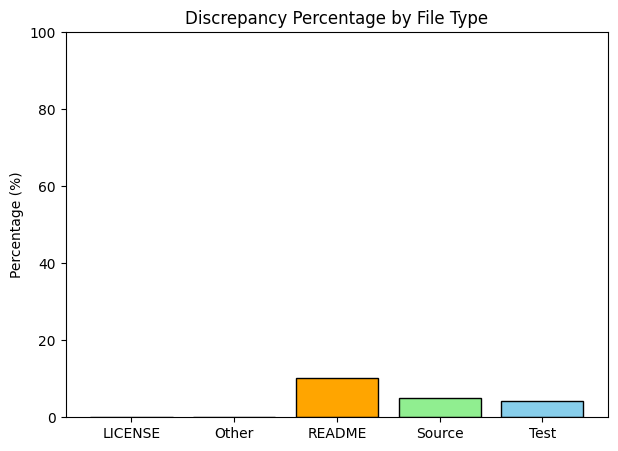

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

total_counts = df.groupby("file_type").size()
discrepancy_counts = df[df["Discrepancy"] == "Yes"].groupby("file_type").size()
discrepancy_percentage = (discrepancy_counts / total_counts * 100).fillna(0)

print("Discrepancy percentage by file type:")
print(discrepancy_percentage)
plt.figure(figsize=(7,5))
plt.bar(discrepancy_percentage.index, discrepancy_percentage.values,
        color=["skyblue","salmon","orange","lightgreen"], edgecolor="black")
plt.title("Discrepancy Percentage by File Type")
plt.ylabel("Percentage (%)")
plt.ylim(0, 100)  
plt.show()
